In [1]:
from arc_prize.model import ARCTransformerEncoderDecoderParams
from arc_prize.train import ARCModelState, ARCTrainParams
from arc_prize.vis import visualize_epochs
import modal
import torch
import petname




In [3]:


from arc_prize.train import train_on_mac


model_params = ARCTransformerEncoderDecoderParams(
  grid_dim=10,
  num_train_pairs=4,
  num_colors=10,
  num_encoder_layers=2,
  num_decoder_layers=2,
  num_heads=2,
  d_model=32,
  d_ff=32*4,
  dropout=0.1
)

train_params = ARCTrainParams(
  batch_size=16,
  learning_rate=3e-4,
  weight_decay=1e-4,
  dataset_dir=["/vol/data/flip"]
)

num_epochs = 100


# model_name = "mainly_cool_gannet"
# model_params = None
# train_params = None


# model_name = petname.generate(words=3, separator='_')
# train_on_mac(model_name, num_epochs, model_params, train_params)



# model_names = ['humbly_caring_piglet', 'namely_noble_swan', 'freely_live_filly']
model_names = []

num_runs = 3

fn = modal.Function.lookup("arc-prize", "train")
for i in range(num_runs):
  # for model_name in model_names:
  model_name = petname.generate(words=3, separator='_')
  fn_call = fn.spawn(model_name, num_epochs, model_params, train_params)
  print("Model name", model_name)
  print(fn_call.object_id)
  model_names.append(model_name)

print(model_names)

    






Model name sadly_warm_midge
fc-01J53XY717PRQ1V3F8TKDF0T4Z
Model name sadly_clear_dodo
fc-01J53XY72S2NNW30T7DZFZWVFE
Model name loudly_viable_corgi
fc-01J53XY74SN7JMH4E13Q3R2DC9
['sadly_warm_midge', 'sadly_clear_dodo', 'loudly_viable_corgi']


daily_modest_amoeba 10 EpochState(train_loss=0.9808797636032105, train_accuracy=0.7464849820137024, val_loss=0.9779645037651062, val_accuracy=0.745399980545044, lr=0.0003, weight_decay=0.0001, beta1=0.9, beta2=0.999, epsilon=1e-08, grad_norm=0.14415752749606828, param_norm=48.06164847082406)


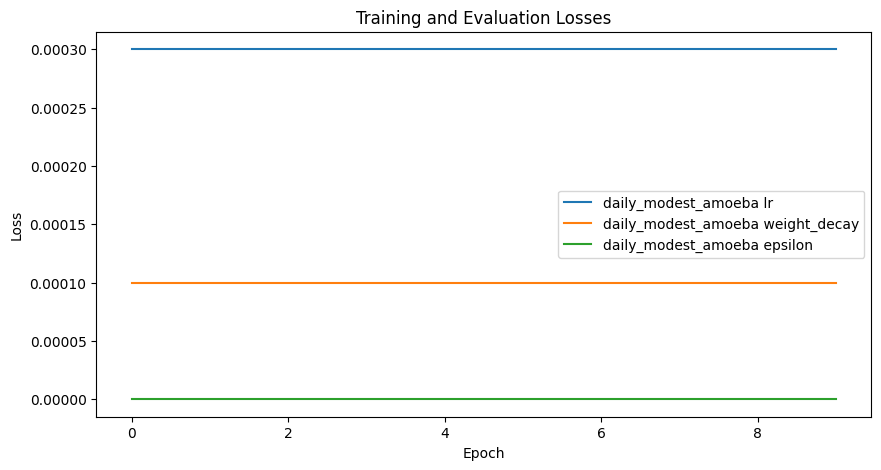

In [2]:
model_names = [
  # "poorly_hip_quagga", # 8 heads
  # "merely_frank_collie", # 4 heads
  "lively_sought_bison", # 2 heads
  # "unduly_gentle_serval", # 2 heads, 1 decoder
  # "purely_large_rabbit", # 2 heads, 1 encoder, 1 decoder
  # "lovely_crisp_ferret", # 4 heads, 1 encoder, 1 decoder, *2 ff
  # "rarely_exotic_goat",
  "merely_merry_pigeon",
  "nicely_eager_rodent",
  "openly_fancy_oriole", # Extra data, batch size 16
  "neatly_still_gannet", # 2000 data, batch size 5
  "lively_useful_dragon"
]

# model_names = [
#   "gladly_fast_eagle", # 12 grid dim
#   "nearly_subtle_guinea", # 30 grid dim
# ]



# 16 dim, one layer on move_random
model_names = ["merely_on_cicada", "gently_model_tuna", "mainly_cool_gannet"]

# Flip 16 dim 2 layers
model_names = ["widely_star_tuna", "overly_rich_toad", "newly_meet_gecko"]

# Flip larger dim layers
model_names = ["kindly_moving_thrush", "fairly_good_worm", "rarely_new_squid"]

# Combined!
model_names = ['humbly_caring_piglet', 'namely_noble_swan', 'freely_live_filly']

model_names = ["sadly_warm_midge", "sadly_clear_dodo", "loudly_viable_corgi"]

epochs = {}


# checkpoint = None
get_model = modal.Function.lookup("arc-prize", "get_model")
for name in model_names:
  checkpoint = ARCModelState(**get_model.remote(name))
  # print(name, checkpoint.model_params)
  print(name, len(checkpoint.epochs), checkpoint.epochs[-1])
  epochs[name] = checkpoint.epochs

visualize_epochs(epochs)

In [ ]:
from arc_prize.vis import visualize_tensors


eval_model = modal.Function.lookup("arc-prize", "evaluate_model")
output = eval_model.remote("mainly_cool_gannet", "/vol/data/flip")
for item in output["output"]:
  visualize_tensors(torch.Tensor(item["grids"]).squeeze(0), torch.Tensor(item["output_grid"]).squeeze(0), torch.Tensor(item["predictions"]).squeeze(0))


In [ ]:
from arc_prize.vis import visualize_output_query, visualize_tensors


# model = ARCTransformer(d_model=d_model, num_heads=num_heads, num_layers=num_layers, d_ff=dim_feedforward, grid_dim=max_grid_size, num_colors=num_colors, num_train_pairs=max_context_pairs, dropout=dropout).to(device)

model_file_name = "models/model_75i3sirg.pth"
if model_file_name is not None:
    state_dict = torch.load(model_file_name, map_location=device)
    model.load_state_dict(state_dict)

model.eval()
eval_loader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=collate_arc_fn, num_workers=0)
# batch = next(iter(eval_loader))

# visualize_output_query(model.output_query)


for i, batch in enumerate(eval_loader):
    grids, grid_masks, output_grid = [item.to(device) for item in batch]

    predictions = model.generate(grids, grid_masks)
    print(predictions.shape)

    visualize_tensors(grids.squeeze(0), output_grid.squeeze(0), predictions.squeeze(0))

